In [11]:
import matplotlib.pyplot as plt
import networkx as nx

from hvectorspaces.io import CockroachClient

In [86]:
id_to_cited_ids = {}
id_to_attrs = {} 

fields = [
    "title", 
    "publication_year", 
    "domain", 
    "field", 
    "topic"
]

with CockroachClient() as client:
    citation_map = client.fetch_per_decade_data(1970, additional_fields=fields)
    for oa_id, refs, title, publication_year, domain, field, topic in citation_map:
        id_to_cited_ids[oa_id] = refs
        id_to_attrs[oa_id] = {
            "title": title,
            "publication_year": publication_year,
            "domain": domain,
            "field": field,
            "topic": topic,
        }

In [114]:
len(id_to_cited_ids.keys())

3462

In [108]:
from collections import Counter

In [110]:
check = []
for r in refs:
    check.append(r in to_nodes)
    
Counter(check)

Counter({True: 1604})

In [157]:
G = nx.DiGraph()

for src, targets in id_to_cited_ids.items():
    for tgt in targets:
        G.add_edge(src, tgt)
        
nx.set_node_attributes(G, id_to_attrs)

In [158]:
len(G.nodes)

2478

In [159]:
sinks = [n for n in G.nodes if G.out_degree(n) == 0]
sources = [n for n in G.nodes if G.in_degree(n) == 0]

In [160]:
len(sources)

874

In [169]:
G.node

{}

In [191]:
topics = [attrs.get("topic") if attrs.get("topic") is not None else "None" for _, attrs in G.nodes(data=True)]
domains = [attrs.get("domain") if attrs.get("domain") is not None else "None" for _, attrs in G.nodes(data=True)]
fields = [attrs.get("field") if attrs.get("field") is not None else "None" for _, attrs in G.nodes(data=True)]

In [203]:
Counter(topics).most_common(30)

[('None', 625),
 ('Particle physics theoretical and experimental studies', 75),
 ('Quantum Chromodynamics and Particle Interactions', 52),
 ('Cosmology and Gravitation Theories', 49),
 ('Black Holes and Theoretical Physics', 48),
 ('Matrix Theory and Algorithms', 43),
 ('Rings, Modules, and Algebras', 39),
 ('Electron and X-Ray Spectroscopy Techniques', 38),
 ('Mathematical Dynamics and Fractals', 32),
 ('Optimization and Variational Analysis', 28),
 ('Advanced Statistical Methods and Models', 26),
 ('Holomorphic and Operator Theory', 25),
 ('Spectral Theory in Mathematical Physics', 25),
 ('Quantum Mechanics and Applications', 24),
 ('Geometric Analysis and Curvature Flows', 24),
 ('Atomic and Molecular Physics', 22),
 ('High-pressure geophysics and materials', 22),
 ('Advanced Algebra and Geometry', 21),
 ('Advanced Topics in Algebra', 21),
 ('Economic theories and models', 21),
 ('Stability and Controllability of Differential Equations', 21),
 ('advanced mathematical theories', 21),

In [193]:
Counter(domains).most_common(10)

[('Physical Sciences', 1623),
 ('None', 625),
 ('Social Sciences', 162),
 ('Life Sciences', 55),
 ('Health Sciences', 13)]

In [194]:
Counter(fields).most_common(20)

[('None', 625),
 ('Physics and Astronomy', 528),
 ('Mathematics', 500),
 ('Computer Science', 214),
 ('Engineering', 185),
 ('Materials Science', 95),
 ('Economics, Econometrics and Finance', 89),
 ('Earth and Planetary Sciences', 59),
 ('Decision Sciences', 39),
 ('Chemistry', 23),
 ('Agricultural and Biological Sciences', 20),
 ('Neuroscience', 19),
 ('Environmental Science', 17),
 ('Business, Management and Accounting', 15),
 ('Biochemistry, Genetics and Molecular Biology', 15),
 ('Medicine', 11),
 ('Social Sciences', 9),
 ('Psychology', 7),
 ('Arts and Humanities', 3),
 ('Energy', 2)]

In [195]:
refs = [t for tgts in id_to_cited_ids.values() for t in tgts]
len(refs)

5163

In [196]:
len(id_to_attrs.keys())

3462

In [197]:
len(to_nodes)

1604

In [198]:
top_topics = 

In [199]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = plt.get_cmap("tab20")   # good for categorical data
topic_to_color = {t: cmap(i % cmap.N) for i, t in enumerate(unique_topics)}
node_colors = [
    topic_to_color[G.nodes[n].get("topic")]
    for n in G.nodes
]
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=70)
nx.draw_networkx_edges(G, pos, arrows=False, alpha=0.2, width=0.5)
plt.axis("off")
plt.show()


KeyError: None

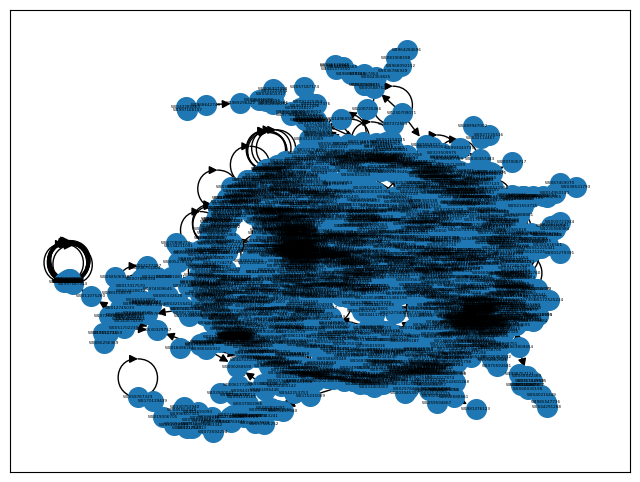

In [93]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx(
    G,
    pos,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=12,
    edge_color="black",
    font_size=3,
    node_size=200,
    with_labels=True
)
plt.show()